In [820]:
# Required libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

In [821]:
# Load data set
df = pd.read_csv("FinDataSet-1.csv")
df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.head()

,Date,CBA,MQG
Date,,,
2013-01-02,2/1/2013,73.134,38.539
2013-01-03,3/1/2013,72.636,37.851
2013-01-04,4/1/2013,72.188,38.235
2013-01-07,7/1/2013,70.754,42.394
2013-01-08,8/1/2013,71.362,43.368


In [822]:
# Current values of financial variables
current_values = df.tail(1).to_numpy()
CBA_price = current_values[0,1]
MQG_price = current_values[0,2]

In [823]:
# Price data
price_df = df.copy()

# Drop other columns
df = df.drop(["Date"], axis=1)

# Calculate the daily log-return:
for col in df.columns.values:
    df.loc[:,col] = np.log(df.loc[:,col]) - np.log(df.loc[:,col].shift(1))

df = df.dropna()
df.head()

,CBA,MQG
Date,,
2013-01-03,-0.006833,-0.018013
2013-01-04,-0.006187,0.010094
2013-01-07,-0.020065,0.103256
2013-01-08,0.008556,0.022715
2013-01-09,-0.019299,0.011486


In [824]:
# Covariance matrix of (daily) log returns
daily_log_ret_cov = np.cov(df, rowvar = False)
daily_log_ret_cov

CBA_ann_vol = np.sqrt(daily_log_ret_cov[0,0] * 250)
MQG_ann_vol = np.sqrt(daily_log_ret_cov[1,1] * 250)

# Portfolio Value

## The entire portfolio value:

$$ V_t = V_{\text{CBA},t} + V_{\text{MQG},t} $$

Where each position value as follows:
$$\begin{align*}
V_{\text{CBA}, t} &= V_{\text{call}, 80} \left( t, S_{CBA,t}, r_t^{(6m)} \right) + V_{\text{call}, 110} \left( t, S_{CBA,t}, r_t^{(6m)} \right) - 2 \times V_{\text{call}, 100} \left( t, S_{CBA,t}, r_t^{(6m)} \right) \\[5pt]
V_{\text{MQG}, t} &= V_{\text{put}, 150} \left( t, S_{MQG,t}, r_t^{(6m)} \right) + V_{\text{call}, 220} \left( t, S_{MQG,t}, r_t^{(6m)} \right)
\end{align*}$$

# 1. Use the Black-Scholes-Merton formula to determine the mark-to-market value

In [825]:
# Pricing function for European calls and puts
def BSprice(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Calculate option prices
    if option_type == 'call':
        price = (np.exp(-q * tau) * s * sp.stats.norm.cdf(d1, 0.0, 1.0) \
                 - np.exp(-r * tau) * K * sp.stats.norm.cdf(d2, 0.0, 1.0))
        
    if option_type == 'put':
        price = (np.exp(-r * tau) * K * sp.stats.norm.cdf(-d2, 0.0, 1.0) \
                 - np.exp(-q * tau) * s * sp.stats.norm.cdf(-d1, 0.0, 1.0))
        
    return price

In [826]:
# Assign values:
rfr = 0.0267
tau = 0.5
dy = 0

# Butterfly spread CBA:
CBA_l_call_strike_80 = 80
CBA_l_call_strike_110 = 110
CBA_s_call_strike_100_x2 = 100

# Strangle MQG:
MQG_l_put_strike_150 = 150
MQG_l_call_strike_220 = 220

# Calculate the mark-to-market value of the butterfly spread:
bs_CBA_long_1 = BSprice(CBA_price, CBA_l_call_strike_80, tau, rfr, dy, CBA_ann_vol, "call")
bs_CBA_long_2 = BSprice(CBA_price, CBA_l_call_strike_110, tau, rfr, dy, CBA_ann_vol, "call")
bs_CBA_short_3 = - 2 * BSprice(CBA_price, CBA_s_call_strike_100_x2, tau, rfr, dy, CBA_ann_vol, "call")
bs_value = bs_CBA_long_1 + bs_CBA_long_2 + bs_CBA_short_3

# Calculate the mark-to-market value of the strangle:
st_MQG_long_1 = BSprice(MQG_price, MQG_l_put_strike_150, tau, rfr, dy, MQG_ann_vol, "put")
st_MQG_long_2 = BSprice(MQG_price, MQG_l_call_strike_220, tau, rfr, dy, MQG_ann_vol, "call")
st_value = st_MQG_long_1 + st_MQG_long_2

In [827]:
print(bs_CBA_long_1)
print(bs_CBA_long_2)
print(bs_CBA_short_3)
print(bs_value)

print(st_MQG_long_1)
print(st_MQG_long_2)
print(st_value)

57.80795551621756
50.10402500659926
-104.87192106017369
3.0400594626431285
2.0312532665039953
3.069401220849919
5.100654487353914


# 2. Implement meethods from (M1) to (M5)

## Risk Factor Mapping

We introduce the following notation:

$$
\mathbf{Z}_t := \begin{bmatrix} Z_{1,t} \\ Z_{2,t} \end{bmatrix} = \begin{bmatrix} \ln S_{CBA,t} \\ \ln S_{MQG,t}  \end{bmatrix}, \quad \mathbf{X}_{t+1} := \mathbf{Z}_{t+1} - \mathbf{Z}_t = \begin{bmatrix} \ln S_{CBA,t+1} - \ln S_{CBA,t} \\ \ln S_{MQG,t+1} - \ln S_{MQG,t} \end{bmatrix}
$$

A mapping, therefore, of the risk factor vector Zt to the current portfolio value is
$$\begin{align*}
V_t &= g(t, \mathbf{Z}_t) \\[5pt]
&:= V_{\text{CBA}} \left( t, e^{Z_{1,t}} \right) + V_{\text{MQG}} \left( t, e^{Z_{2,t}} \right).
\end{align*}$$

## 2.1. (M1) Analytical delta-normal approach

In [828]:
# Create dataframe to store value
portfolio_risk_measures = pd.DataFrame(columns=['method', 'position', 'type', 'conf_level', 'risk_measure'])

# Confidence level
conf_level_list = [0.9, 0.95, 0.99]

In [829]:
# Function to calculate option delta under the Black-Scholes-Merton model
def BSdelta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    
    # Calculate option delta
    if option_type == 'call':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0)
    
    if option_type == 'put':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0) - 1
    
    return value    

In [830]:
def delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol): 
    # Call Option Risk Factor Exposures
    # - Call delta
    call_delta_CBA_80 = BSdelta(CBA_price, CBA_l_call_strike_80, tau, 
                         rfr, dy, CBA_ann_vol, option_type = 'call')
    call_delta_CBA_110 = BSdelta(CBA_price, CBA_l_call_strike_110, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
    call_delta_CBA_100_x2 = BSdelta(CBA_price, CBA_s_call_strike_100_x2, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
    
    call_delta_MQG_220 = BSdelta(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'call')
    
    # Put Option Risk Factor Exposures
    # - Put delta
    put_delta_MQG_150 = BSdelta(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'put')
    
    # Butterfly Spread Risk Factor Exposures
    B_exposure_delta_1 = (call_delta_CBA_80 + call_delta_CBA_110 - 2*call_delta_CBA_100_x2) * CBA_price
    B_exposure_delta_2 = 0
    B_exposure_delta = np.array([B_exposure_delta_1, B_exposure_delta_2])
    
    # Strangle Risk Factor Exposures
    S_exposure_delta_1 = 0
    S_exposure_delta_2 = (call_delta_MQG_220 - put_delta_MQG_150) * MQG_price
    S_exposure_delta = np.array([S_exposure_delta_1, S_exposure_delta_2])

    return [B_exposure_delta, S_exposure_delta]

In [831]:
exposure_delta = delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)

In [832]:
# Mean log-returns
daily_log_ret_mean = np.mean(df, axis = 0)
daily_log_ret_mean

# 10-day log-returns mean
log_ret_mean_10days = daily_log_ret_mean * 10

# 10-day Covariance
log_ret_cov_10days = daily_log_ret_cov * 10

In [833]:
# Functions for VaR and ES under the variance-covariance approach
def VaR_ES_vcv(constant_loss, risk_exposure, risk_factor_mean, risk_factor_cov_mat, conf_level):

    # Shorthand notation for inputs
    c = constant_loss
    b = risk_exposure
    mu = risk_factor_mean
    Sigma = risk_factor_cov_mat
    alpha = conf_level

    # Compute mean and variance of loss
    loss_mean = -c - np.transpose(b) @ mu
    loss_var = np.transpose(b) @ Sigma @ b

    # Compute VaR
    VaR = loss_mean + np.sqrt(loss_var) * stats.norm.ppf(alpha, loc = 0.0, scale = 1.0)
    VaR = max(VaR, 0)

    # Compute ES
    ES = loss_mean + np.sqrt(loss_var) * stats.norm.pdf(stats.norm.ppf(alpha, loc = 0.0, scale = 1.0), loc = 0.0, scale = 1.0) / (1 - alpha)
    ES = max(ES, 0)

    # Return output
    return np.array([VaR, ES])

In [834]:
# Portfolio Risk Measures
portfolio_exposure_M1 = exposure_delta[0] + exposure_delta[1]

# Compute 1-day VaR and ES
new_rows = []
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, portfolio_exposure_M1, daily_log_ret_mean, daily_log_ret_cov, i)
    new_row = {'method': 'M1', 'position': 'entire', 'type': '1-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

# Compute 10-day VaR and ES
new_rows = []
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, portfolio_exposure_M1, log_ret_mean_10days, log_ret_cov_10days, i)
    new_row = {'method': 'M1', 'position': 'entire', 'type': '10-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Add new 10-day rows portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

print(portfolio_risk_measures)

  method position    type  conf_level  \
0     M1   entire   1-day        0.90   
1     M1   entire   1-day        0.95   
2     M1   entire   1-day        0.99   
3     M1   entire  10-day        0.90   
4     M1   entire  10-day        0.95   
5     M1   entire  10-day        0.99   

                               risk_measure  
0    [3.733567838520358, 5.155862200759873]  
1     [4.825008092797876, 6.08035007602825]  
2    [6.872368494364309, 7.890398421706166]  
3  [11.009995104432313, 15.507684792325762]  
4   [14.461432237942603, 18.43117214738348]  
5    [20.9357542981295, 24.155047594745493]  


## 2.2. (M2) Historical simulation approach with a delta-gamma approximation

In [835]:
# Function to calculate option gamma under the Black-Scholes-Merton model
def BSgamma(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Compute option gamma (same for calls and puts)
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    value = sp.stats.norm.pdf(d1, 0.0, 1.0) / (s * sigma * np.sqrt(tau))
    
    return value

In [836]:
def delta_gamma_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol):   
    # Call Option Risk Factor Exposures
    # - Call delta-gamma
    call_dg_CBA_80 = BSgamma(spot_price = CBA_price, strike_price = CBA_l_call_strike_80, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    call_dg_CBA_110 = BSgamma(spot_price = CBA_price, strike_price = CBA_l_call_strike_110, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    call_dg_CBA_100_x2 = BSgamma(spot_price = CBA_price, strike_price = CBA_s_call_strike_100_x2, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    
    call_dg_MQG_220 = BSgamma(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)
    
    # Put Option Risk Factor Exposures
    # - Put delta-gamma
    put_dg_MQG_150 = BSgamma(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)

    # Compute delta
    exposure_delta = delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)
    
    # Butterfly Spread Risk Factor Exposures
    B_exposure_dg_1 = exposure_delta[0][0] + (call_dg_CBA_80 + call_dg_CBA_110 - 2*call_dg_CBA_100_x2) * (CBA_price**2)
    B_exposure_dg_2 = 0
    B_exposure_dg = np.array([B_exposure_dg_1, B_exposure_dg_2])
    
    # Strangle Risk Factor Exposures
    S_exposure_dg_1 = 0
    S_exposure_dg_2 = exposure_delta[1][1] + (call_dg_MQG_220 - put_dg_MQG_150) * (MQG_price**2)
    S_exposure_dg = np.array([S_exposure_dg_1, S_exposure_dg_2])

    return [B_exposure_dg, S_exposure_dg]

In [837]:
# Calculate loss for each historical scenario  len(df)+1
loss_scenario = pd.DataFrame(columns=['scenario', 'loss'])
for i in range(250, len(df)-250):
    log_return = df.iloc[i:i+249]
    log_return_change = df.iloc[i+250]
  
    daily_log_ret_cov_i = np.cov(log_return, rowvar = False)  
    CBA_ann_vol_i = np.sqrt(daily_log_ret_cov_i[0,0] * 250)
    MQG_ann_vol_i = np.sqrt(daily_log_ret_cov_i[1,1] * 250)
    
    current_values_i = price_df.iloc[i+250]
    CBA_price_i = current_values_i[1]
    MQG_price_i = current_values_i[2]

    # Calculate delta for entire portfolio
    exposure_delta_B_i = delta_approx(CBA_price_i, MQG_price_i, CBA_ann_vol_i, MQG_ann_vol_i)[0]
    exposure_delta_S_i = delta_approx(CBA_price_i, MQG_price_i, CBA_ann_vol_i, MQG_ann_vol_i)[1]
    exposure_delta_i = exposure_delta_B_i + exposure_delta_S_i

    # Calculate delta-gamma for entire portfolio
    exposure_dg_B_i = delta_gamma_approx(CBA_price_i, MQG_price_i, CBA_ann_vol_i, MQG_ann_vol_i)[0]
    exposure_dg_S_i = delta_gamma_approx(CBA_price_i, MQG_price_i, CBA_ann_vol_i, MQG_ann_vol_i)[1]
    exposure_dg_i = exposure_dg_B_i + exposure_dg_S_i

    # Potential loss
    loss = - (np.transpose(exposure_delta_i) @ log_return_change + 1/2 * np.transpose(exposure_dg_i) @ (log_return_change**2))
    loss_B = - (np.transpose(exposure_delta_B_i) @ log_return_change + 1/2 * np.transpose(exposure_dg_B_i) @ (log_return_change**2))
    loss_S = - (np.transpose(exposure_delta_S_i) @ log_return_change + 1/2 * np.transpose(exposure_dg_S_i) @ (log_return_change**2))

    # Store loss value
    new_row = [{'scenario': i-249, 'loss': loss, 'loss_B': loss_B, 'loss_S': loss_S}]
    loss_scenario = pd.concat([loss_scenario, pd.DataFrame(new_row)], ignore_index=True)

In [838]:
# Rank all potential loss
loss_scenario = loss_scenario.sort_values(by='loss', ascending=False)

# Compute VaR and ES
new_rows = []
for i in conf_level_list:

    # Get most extram 1-conf level scenario
    threshold = 1-i
    ind = math.ceil(threshold * len(loss_scenario)) - 1

    # Compute VaR and ES for 1-day
    VaR = loss_scenario.iloc[ind]['loss']
    ES = np.mean(loss_scenario.iloc[:ind]['loss'])

    # 1-day
    risk_measure = [VaR, ES]
    new_row_1 = {'method': 'M2', 'position': 'entire', 'type': '1-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row_1)
    
    # 10-day
    risk_measure = [VaR * np.sqrt(10), ES * np.sqrt(10)]
    new_row_2 = {'method': 'M2', 'position': 'entire', 'type': '10-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row_2)

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

In [839]:
portfolio_risk_measures

,method,position,type,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.0315612893881068, 3.976577056950959]"
7,M2,entire,10-day,0.90,"[6.424360880694878, 12.575040791134139]"
8,M2,entire,1-day,0.95,"[3.1568879852364926, 5.400455578503773]"
9,M2,entire,10-day,0.95,"[9.982956351367326, 17.077740030634182]"


## 2.3. (M3) Historical simulation approach with a delta-gamma approximation

In [840]:
# Assign lambda
lambda_ = 0.995
n = len(df)-250 - 250 + 1

# Create weight and cumulative weight column
loss_scenario['weight'] = (lambda_ ** (n-loss_scenario['scenario'])) * (1-lambda_) / (1 - lambda_ ** n)
loss_scenario['cum_weight'] = loss_scenario['weight'].cumsum()

# Calculate VaR and ES for each confidence level
new_rows = []
for i in conf_level_list:
    # Detect index of Var value
    threshold = 1 - i
    ind = len(loss_scenario[loss_scenario['cum_weight'] < threshold])

    # Compute VaR and ES for 1-day
    VaR = loss_scenario.iloc[ind]['loss']
    ES = (np.sum(loss_scenario.iloc[:ind-1]['loss'] * loss_scenario.iloc[:ind-1]['weight']) + VaR * (1 - np.sum(loss_scenario.iloc[:ind-1]['weight']))) / threshold

    # 1-day
    risk_measure = [VaR, ES]
    new_row_1 = {'method': 'M3', 'position': 'entire', 'type': '1-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row_1)
    
    # 10-day
    risk_measure = [VaR * np.sqrt(10), ES * np.sqrt(10)]
    new_row_2 = {'method': 'M3', 'position': 'entire', 'type': '10-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row_2)

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

In [841]:
portfolio_risk_measures

,method,position,type,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.0315612893881068, 3.976577056950959]"
7,M2,entire,10-day,0.90,"[6.424360880694878, 12.575040791134139]"
8,M2,entire,1-day,0.95,"[3.1568879852364926, 5.400455578503773]"
9,M2,entire,10-day,0.95,"[9.982956351367326, 17.077740030634182]"


# 3. Risk Measures for a standalone basis for each position

## 3.1. (M1) Analytical delta-normal approach

In [842]:
# Compute 1-day VaR and ES 
new_rows = []
risk_measure_B = VaR_ES_vcv(0, B_exposure_delta, daily_log_ret_mean, daily_log_ret_cov, 0.95)
risk_measure_S = VaR_ES_vcv(0, S_exposure_delta, daily_log_ret_mean, daily_log_ret_cov, 0.95)
new_row = {'method': 'M1', 'position': 'standalone', 'type': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure_B + risk_measure_S}
new_rows.append(new_row)

# Add new 1-day 95% conf level row  to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

## 3.2. (M2) Historical simulation approach with a delta-gamma approximation

In [843]:
# Compute VaR and ES
# Get most extram 1-conf level scenario
threshold = 1 - 0.95
ind = math.ceil(threshold * len(loss_scenario)) - 1

# Compute VaR and ES for 1-day
# Rank all potential loss by Butterfly spread
loss_scenario = loss_scenario.sort_values(by='loss_B', ascending=False)
VaR_B = loss_scenario.iloc[ind]['loss_B']
ES_B = np.mean(loss_scenario.iloc[:ind]['loss_B'])

# Rank all potential loss by Strangle
loss_scenario = loss_scenario.sort_values(by='loss_S', ascending=False)
VaR_S = loss_scenario.iloc[ind]['loss_S']
ES_S = np.mean(loss_scenario.iloc[:ind]['loss_S'])

new_rows = []
# 1-day risk measure
risk_measure = [VaR_B + VaR_S, ES_B + ES_S]
new_row_1 = {'method': 'M2', 'position': 'standalone', 'type': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure}
new_rows.append(new_row_1)

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

In [845]:
portfolio_risk_measures

,method,position,type,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.0315612893881068, 3.976577056950959]"
7,M2,entire,10-day,0.90,"[6.424360880694878, 12.575040791134139]"
8,M2,entire,1-day,0.95,"[3.1568879852364926, 5.400455578503773]"
9,M2,entire,10-day,0.95,"[9.982956351367326, 17.077740030634182]"


# 4. Extra Material

## 4.1. Stock Price Time Series

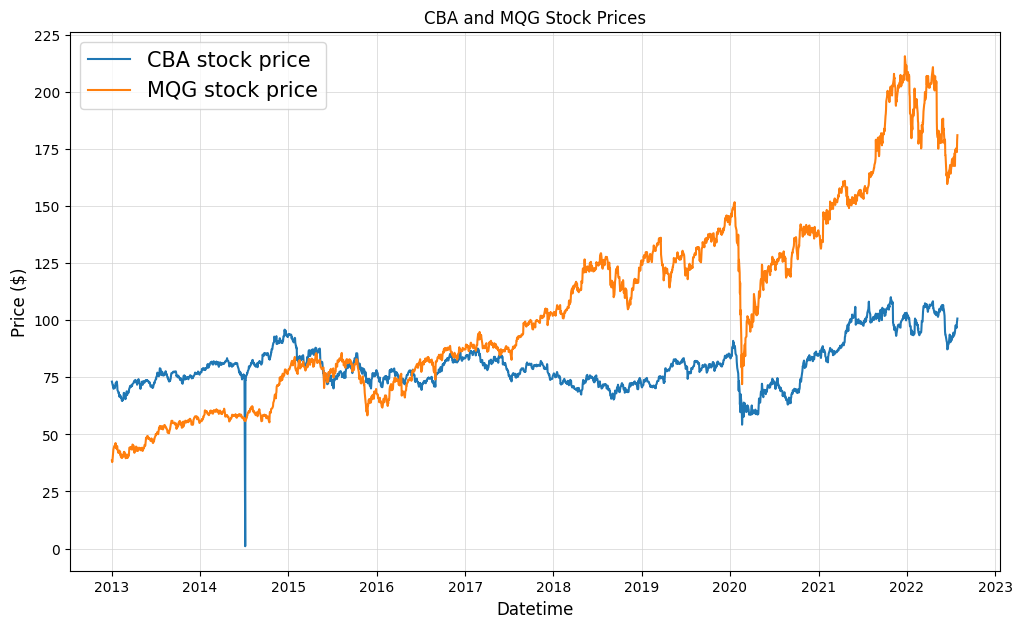

In [215]:
plt.plot(price_df.index, price_df['CBA'], label='CBA stock price')
plt.plot(price_df.index, price_df['MQG'], label='MQG stock price')
plt.title("CBA and MQG Stock Prices")
plt.legend(fontsize="15")

# Set labels and ticks
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.yticks(range(0, 250, 25))  # This will set ticks at intervals of 25 up to 250

# Design figure
fig = plt.gcf()  # Get the current figure
fig.set_size_inches(12, 7, forward=True)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)

# Defining and displaying all time axis ticks
# ticks = list(price_df.index)
# plt.xticks(ticks, rotation=45)

## 4.2. Dependence of Log-Returns

In [216]:
# Linear correlation
np.corrcoef(df, rowvar = False)

array([[1.        , 0.08176529],
       [0.08176529, 1.        ]])

In [218]:
# Kendall's tau
log_ret_tau = stats.kendalltau(df['CBA'], df['MQG'])
log_ret_tau

SignificanceResult(statistic=np.float64(0.38801030996245117), pvalue=np.float64(4.0322349304386595e-179))

In [219]:
# Spearman's rho
log_ret_srho = stats.spearmanr(df, axis = 0)
log_ret_srho

SignificanceResult(statistic=np.float64(0.5338567747986649), pvalue=np.float64(7.024525769634955e-178))

In [221]:
# Required library
from pycop import empirical

# Empirical copula
em_cop = empirical(df.T.values)

# Non-parametric TDC estimates where k_l / n = 1% and k_u / n = 99%
em_cop.LTDC(0.01), em_cop.UTDC(0.99)

(np.float64(0.4144218814753419), np.float64(0.342312474098638))

In [849]:
test = pd.Series([20.2, 10.1, 50.2, 40.2, 30.5])
quantile_value = test.quantile(0.95, interpolation='lower')
quantile_value

np.float64(40.2)